### Download Data

In [1]:
import pandas as pd
import numpy as np
# read data to pandas frame
url = 'https://raw.githubusercontent.com/Dr-Ning-An/Deep-Learning-with-Keras/main/NonlinearRegression/Data.csv'
data = pd.read_csv(url)
data.shape
# print(data.head(5))

(10000, 4)

In [2]:
inputs = data.iloc[:, 0:2]
n_inputs = inputs.shape[1]
print(inputs.head(5))
outputs = data.iloc[:, 2:4]
n_outputs = outputs.shape[1]
print(outputs.head(5))

   Coordinate x [m]  Distributed load q [kN/m]
0          1.939494                   1.093709
1          1.089809                   1.935594
2          1.239824                   1.229323
3          1.590659                   1.019202
4          1.234323                   1.867587
   Displacement u [m]  Curvature kappa [m-1]
0            7.979345              12.727456
1            2.505332              12.656563
2            2.342859               9.144864
3            4.101961               9.727217
4            3.512107              13.831237


In [3]:
from sklearn.model_selection import train_test_split
# Randomly split the data into a training and test sets by holding 30% of the data for testing.
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, test_size = 0.3, random_state=0)

In [4]:
import keras
from keras.layers import Dense
import tensorflow as tf

# define regression model using Functional API
def build_model():
    # create model
    inputs = tf.keras.Input(shape=(n_inputs,), dtype=tf.float64)
    dense1 = Dense(128, activation='tanh')(inputs)
    dense2 = Dense(64, activation='tanh')(dense1)
    dense3 = Dense(32, activation='tanh')(dense2)
    dense4 = Dense(16, activation='tanh')(dense3)
    outputs = Dense(n_outputs)(dense4)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
# build the model
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 11,282
Trainable params: 11,282
Non-trainable p

In [6]:
optimizer = tf.keras.optimizers.Adam()

In [7]:
BATCH_SIZE = 60
EPOCHS = 200

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((inputs_train, outputs_train))
dataset = dataset.batch(BATCH_SIZE)

In [9]:
def PGNN(x, q):
    x = tf.Variable(x)
    q = tf.Variable(q)
    with tf.GradientTape() as g:
      g.watch(x)
      with tf.GradientTape() as gg:
        gg.watch(x)
        outputs_pred = tf.cast(model(tf.stack([x,q], axis=1)), tf.float64)
        u = outputs_pred[:,0]
      du_dx = gg.gradient(u, x)  
    d2u_dx2 = g.gradient(du_dx, x)  

    kappa = outputs_pred[:,1]
    
    residual = d2u_dx2 - kappa

    return residual

def train_step(inputs, outputs):
    with tf.GradientTape() as tape:
        outputs_pred = tf.cast(model(inputs), tf.float64)
        residual = PGNN(inputs[:,0],inputs[:,1])
        loss1 = tf.losses.MeanSquaredError()(outputs, outputs_pred) 
        loss2 = tf.reduce_mean(tf.square(residual))
        loss = loss1 + loss2

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

loss_hist = []
for epoch in range(EPOCHS):
    ep_loss = []
    for step, (inputs_norm_train_batch, outputs_norm_train_batch) in enumerate(dataset):
        loss_i = train_step(inputs_norm_train_batch, outputs_norm_train_batch)
        ep_loss.append(loss_i)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} Loss: {tf.reduce_mean(ep_loss)}")

Epoch 0 Loss: 73.76700599467839
Epoch 1 Loss: 45.62852039825756
Epoch 2 Loss: 28.676455381309136
Epoch 3 Loss: 18.80901364244619
Epoch 4 Loss: 14.827245861029658
Epoch 5 Loss: 13.322682843587504
Epoch 6 Loss: 10.955906778039806
Epoch 7 Loss: 8.940944005795831
Epoch 8 Loss: 7.312992086228137
Epoch 9 Loss: 7.085952375521294
Epoch 10 Loss: 5.285859128383625
Epoch 11 Loss: 5.408859245568283
Epoch 12 Loss: 4.676660736914265
Epoch 13 Loss: 3.3632859704739575
Epoch 14 Loss: 8.438764690349402
Epoch 15 Loss: 3.5115369799380503
Epoch 16 Loss: 3.00939362786487
Epoch 17 Loss: 4.013289753317469
Epoch 18 Loss: 1.8187492484410996
Epoch 19 Loss: 2.3762048272790155
Epoch 20 Loss: 2.1076036383924546
Epoch 21 Loss: 10.164446498760874
Epoch 22 Loss: 3.529554849582007
Epoch 23 Loss: 2.2422540327148672
Epoch 24 Loss: 1.8982720533996185
Epoch 25 Loss: 1.221826606746791
Epoch 26 Loss: 0.7518362853550309
Epoch 27 Loss: 0.5698797771163892
Epoch 28 Loss: 0.6129227678428685
Epoch 29 Loss: 0.44015002055694347
Epoc

In [10]:
disp_test = outputs_test.to_numpy()[:,0]
kappa_test = outputs_test.to_numpy()[:,1]

In [11]:
outputs_pred = model.predict(inputs_test)
outputs_pred_df = pd.DataFrame(outputs_pred, columns = ['Displacement u [m]','Curvature kappa [m-1]'])
print(outputs_pred_df)
disp_pred = outputs_pred_df.to_numpy()[:,0]
kappa_pred = outputs_pred_df.to_numpy()[:,1]

94/94 [==============================] - 0s 1ms/step
      Displacement u [m]  Curvature kappa [m-1]
0               2.383660               9.332182
1               2.219666               9.729347
2               2.849844              11.651175
3              13.008905              20.430679
4               6.445101              14.559344
...                  ...                    ...
2995           11.016376              19.466827
2996            3.909731               9.740879
2997           13.553029              20.606590
2998           12.140396              18.524708
2999            4.632543              13.576095

[3000 rows x 2 columns]


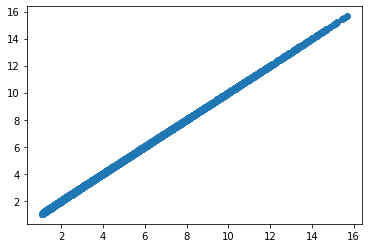

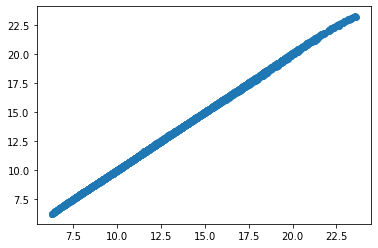

In [12]:
import matplotlib.pyplot as plt
plt.plot(disp_test, disp_pred, 'o')
plt.show()
plt.plot(kappa_test, kappa_pred, 'o')
plt.show()

In [13]:
import tensorflow as tf
def F_model(model,x,q):
    x = tf.Variable(x)
    q = tf.Variable(q)
    with tf.GradientTape() as g:
      g.watch(x)
      with tf.GradientTape() as gg:
        gg.watch(x)
        u = model(tf.stack([x,q], axis=1))[:,0]
      du_dx = gg.gradient(u, x)  
    d2u_dx2 = g.gradient(du_dx, x)  
    return u, d2u_dx2

tf.Tensor(
[ 9.30543518  9.70587921 11.63918495 ... 20.46994781 18.41417313
 13.53708649], shape=(3000,), dtype=float64)


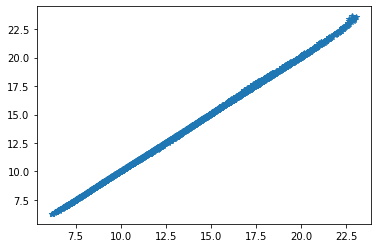

In [14]:
x = inputs_test.to_numpy()[:,0]
q = inputs_test.to_numpy()[:,1]
[u, d2u_dx2] = F_model(model, x,q)
print(d2u_dx2)
plt.plot(d2u_dx2, kappa_test, '*')
plt.show()